# 交差検証まとめ

- ref: https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
- blog: https://slash-z.com/
- github: https://github.com/KazutoMakino/PythonCourses

---

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
sns.set()

In [2]:
iris = sns.load_dataset(name="iris")
print(iris)

     sepal_length  sepal_width  petal_length  petal_width    species
0             5.1          3.5           1.4          0.2     setosa
1             4.9          3.0           1.4          0.2     setosa
2             4.7          3.2           1.3          0.2     setosa
3             4.6          3.1           1.5          0.2     setosa
4             5.0          3.6           1.4          0.2     setosa
..            ...          ...           ...          ...        ...
145           6.7          3.0           5.2          2.3  virginica
146           6.3          2.5           5.0          1.9  virginica
147           6.5          3.0           5.2          2.0  virginica
148           6.2          3.4           5.4          2.3  virginica
149           5.9          3.0           5.1          1.8  virginica

[150 rows x 5 columns]


In [3]:
df = iris.sample(n=100, random_state=42)
df.sort_values(by="species", inplace=True)
df.reset_index(drop=True, inplace=True)

ここで，後ほどラベルでないグループでデータを分けることもある都合で，「調査した地域」という意味合いで，上から順番に "area" という名称でカラムを以下のように追加します．

In [4]:
df["area"] = (
    ["A"] * 50
    + ["B"] * 20
    + ["C"] * 15
    + ["D"] * 10
    + ["E"] * 5
)
print(df)

    sepal_length  sepal_width  petal_length  petal_width    species area
0            5.2          3.5           1.5          0.2     setosa    A
1            4.9          3.1           1.5          0.2     setosa    A
2            5.0          3.4           1.6          0.4     setosa    A
3            5.0          3.2           1.2          0.2     setosa    A
4            5.1          3.8           1.9          0.4     setosa    A
..           ...          ...           ...          ...        ...  ...
95           6.3          2.7           4.9          1.8  virginica    E
96           7.7          3.8           6.7          2.2  virginica    E
97           5.7          2.5           5.0          2.0  virginica    E
98           5.8          2.7           5.1          1.9  virginica    E
99           7.2          3.2           6.0          1.8  virginica    E

[100 rows x 6 columns]


In [5]:
# features / objectives
x = df[[v for v in df.columns if v!="species"]]
y = df["species"]
group = df["area"]
print(f"x.shape={x.shape}, y.shape={y.shape}, group.shape={group.shape}")

x.shape=(100, 5), y.shape=(100,), group.shape=(100,)


In [6]:
print(y.value_counts())

setosa        37
versicolor    32
virginica     31
Name: species, dtype: int64


データ分割可視化用の関数を定義

In [7]:
class FoldsPlotter:
    """ Create a sample plot for indices of a cross-validation object.

    ref:
    - https://scikit-learn.org/stable/auto_examples/model_selection/plot_cv_indices.html
    """
    def __init__(
        self, x: pd.DataFrame,
        y: pd.Series,
        group: pd.Series,
        ylabel: str = "Fold indices",
        lw: int = 10,
    ) -> None:
        self.x = x
        self.y = y
        self.group = group

        # set encoder and transformed data
        enc = LabelEncoder()
        self.enc_y = enc.fit_transform(y)
        self.enc_group = enc.fit_transform(group)

        # line width
        self.lw = lw

        # plot y-axis label
        self.ylabel = ylabel

        # init
        self.fold_num = 0
        fig = plt.figure(figsize=(8, 4))
        self.ax = fig.add_subplot()

    def __del__(self) -> None:
        pass

    def get_legends(
        self,
        label_names: tuple,
        cmap_name: str = "coolwarm",
        bbox_to_anchor: tuple = (1, 1),
        loc: str = "best",
        ncol: int = 5,
        leg_title: str = "title",
    ) -> None:
        # init
        handles = []
        labels = []

        # get legend
        for i, label in enumerate(label_names):
            if len(label_names) == 1:
                color_idx = 0
            else:
                color_idx = i / (len(label_names) - 1)
            color = plt.get_cmap(cmap_name)(color_idx)
            p, = self.ax.plot([-10, -11], [-10, -10], label=label, color=color)
            handles.append(p)
            labels.append(p.get_label())
        legends = self.ax.legend(
            handles=handles,
            labels=labels,
            bbox_to_anchor=bbox_to_anchor,
            loc=loc,
            ncol=ncol,
            title=leg_title,
        )
        plt.gca().add_artist(legends)

    def add_plot(
        self,
        train_idx: np.ndarray = None,
        test_idx: np.ndarray = None,
        cmap="cool",
    ) -> None:
        if (train_idx is None) or (test_idx is None):
            return
        # fill in indices with the training / test groups
        indices = np.array([np.nan] * len(self.x))
        indices[train_idx] = 0
        indices[test_idx] = 1

        # scatter plot
        self.ax.scatter(
            x=range(len(indices)),
            y=[self.fold_num + 0.5] * len(indices),
            c=indices,
            marker="_",
            lw=self.lw,
            cmap=cmap,
        )

        # get legend
        if self.fold_num == 0:
            self.get_legends(
                label_names=("train", "test"),
                cmap_name=cmap,
                bbox_to_anchor=(1, 1),
                loc="lower right",
                leg_title="train / test",
            )

        # increment
        self.fold_num += 1

    def show(self, custom_y_label: list = None) -> None:
        # set cmap
        cmap_class = "Paired"
        cmap_group = "rainbow"

        # plot the data classes and groups at the end
        self.ax.scatter(
            range(len(self.x)),
            [self.fold_num + 0.5] * len(self.x),
            c=self.enc_y,
            marker="_",
            lw=self.lw,
            cmap=cmap_class,
        )
        self.ax.scatter(
            range(len(self.x)),
            [self.fold_num + 1.5] * len(self.x),
            c=self.enc_group,
            marker="_",
            lw=self.lw,
            cmap=cmap_group,
        )

        # get legends
        self.get_legends(
            label_names=sorted(set(self.y)),
            cmap_name=cmap_class,
            bbox_to_anchor=(0, 1),
            loc="lower left",
            leg_title="class",
        )
        self.get_legends(
            label_names=sorted(set(self.group)),
            cmap_name=cmap_group,
            bbox_to_anchor=(0, -0.15),
            loc="upper left",
            leg_title="group",
        )

        # formatting
        if custom_y_label:
            yticklabels = custom_y_label
        else:
            yticklabels = (
                [f"fold-{str(v)}" for v in range(self.fold_num)] + ["class", "group"]
            )
        self.ax.set(
            yticks=np.arange(self.fold_num + 2) + 0.5,
            yticklabels=yticklabels,
            xlabel="Sample index",
            ylabel=self.ylabel,
            ylim=[self.fold_num + 2.2, -0.2],
            xlim=[0, 100],
        )

        plt.tight_layout()
        plt.show()
        plt.clf()
        plt.close("all")

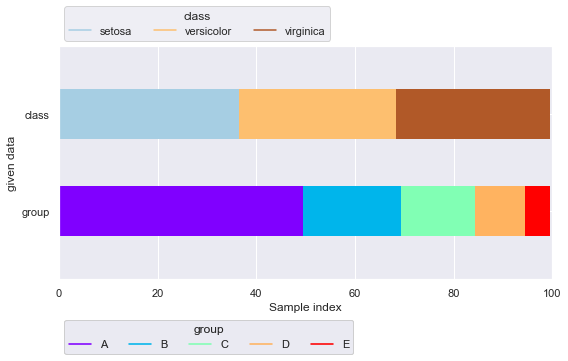

In [8]:
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="given data", lw=50)
plotter.show()

| クラス／関数 | 説明 |
| - | - |
| sklearn.model_selection.check_cv(cv=5, y=None, *, classifier=False) | cross-validator オブジェクト（KFold など）について確認ができます． |
| sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None) | 学習用データと検証用データを2つに分けます（ホールド・アウト検証）． |
| sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None) | データを指定した K 個に等分し，1 つを検証用，それ以外の K-1 個を学習に用います．各 fold における検証用データに重複はさせないようにします． |
| sklearn.model_selection.ShuffleSplit(n_splits=10, *, test_size=None, train_size=None, random_state=None) | train_test.split(shuffle=True, stratify=None) を複数回作用させるような学習用／検証用データのインデックスを返すオブジェクトを生成します．各 fold における検証用データは重複します． |
| sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None) | データを指定した K 個に等分し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割の際には，メソッド split の引数 y にてラベルやグループを指定することにより，全種類のラベルも均等に分割されます．各 fold における検証用データに重複はさせないようにします． |
| sklearn.model_selection.StratifiedShuffleSplit(n_splits=10, *, test_size=None, train_size=None, random_state=None) | train_test.split(shuffle=True, stratify=y) を複数回作用させるような学習用／検証用データのインデックスを返すオブジェクトを生成します．各 fold における検証用データは重複します． |
| sklearn.model_selection.GroupKFold(n_splits=5) | データを指定した K 個に分割し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割の際には，メソッド split の引数 groups にて指定したグループによって，分割するインデックスを制御します．各 fold における検証用データに重複させないようにします． |
| sklearn.model_selection.GroupShuffleSplit(n_splits=5, *, test_size=None, train_size=None, random_state=None) | GroupKFold のデータ分割で，各 fold 間におけるグループの重複を許したデータ分割手法． |
| sklearn.model_selection.StratifiedGroupKFold(n_splits=5, shuffle=False, random_state=None) | データを指定した K 個に分割し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割は，メソッド split の引数 y にて指定したラベル，groups にて指定したグループを用いて，グループのまとまりを使ってラベルを K 個に均等に分けるように作用します．イメージとしては，名前の通り StratifiedKFold と GroupKFold が合体したものです．各 fold における検証用データのグループは重複しません． |
| sklearn.model_selection.RepeatedKFold(*, n_splits=5, n_repeats=10, random_state=None) | KFold を n_repeats で指定した回数分行います．リピートされる各 fold 間では検証用データの重複はありませんが，各リピート間では検証用データの重複は発生します． |
| sklearn.model_selection.RepeatedStratifiedKFold(*, n_splits=5, n_repeats=10, random_state=None) | StratifiedKFold を n_repeats で指定した回数分行います．リピートされる各 fold 間では検証用データの重複はありませんが，各リピート間では検証用データの重複は発生します． |
| sklearn.model_selection.LeaveOneOut() | 一つだけを検証用データ，その他は学習用データとして分割します． |
| sklearn.model_selection.LeavePOut(p) | 引数 p で指定した個数を検証用データ，その他を学習用データとして分割します．検証用データが複数の場合は，検証用データの組み合わせが各 fold にて重複しないように，網羅的に fold が設定されます．例えば，データ数が m 個，引数 p を n 個と設定すると，総 fold 数は数学の組み合わせの記号 C を用いて，mCn = m*(m-1) / (n*(n-1)) 個生成されます． |
| sklearn.model_selection.LeaveOneGroupOut() | 1 つのグループを検証用データとし，それ以外を学習用データとして分割します． |
| sklearn.model_selection.LeavePGroupsOut(n_groups) | 引数 n_groups で指定したグループ数を検証用データ，その他を学習用データとして分割します．検証用データが複数の場合は，検証用データの組み合わせが各 fold にて重複しないように，網羅的に fold が設定されます．例えば，グループ数が m 個，引数 n_groups を n 個と設定すると，総 fold 数は数学の組み合わせの記号 C を用いて，mCn = m*(m-1) / (n*(n-1)) 個生成されます． |
| sklearn.model_selection.PredefinedSplit(test_fold) | 引数 test_fold に指定した fold でデータを分割します． |
| sklearn.model_selection.TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0) | 時系列データを考慮したデータ分割手法で，検証用データを K 等分し，残りの検証用データよりも前のデータを学習用データとして用います．したがって，index=0 から始まるような検証用データにおける学習用データは取れないので，検証用データは K-1 個になります．引数 n_splits では，この K-1 を指定します． |

## sklearn.model_selection.check_cv

```
sklearn.model_selection.check_cv(cv=5, y=None, *, classifier=False)
・・・・cross-validator オブジェクト（KFold など）について確認ができます．
  - cv: cross-validator オブジェクト．int の場合は sklearn.model_selection.KFold において，何分割するかという引数の n_splits が指定できる．None の場合は KFold(n_splits=5)．
  - y: 教師あり学習における目的変数．
  - classifier: ==True でクラス分類タスクの場合は，sklearn.model_selection.StratifiedKFold が用いられます．
```

In [9]:
from sklearn.model_selection import check_cv
print(check_cv())

KFold(n_splits=5, random_state=None, shuffle=False)


In [10]:
print(check_cv(y=y, classifier=False))
print(check_cv(y=y, classifier=True))

KFold(n_splits=5, random_state=None, shuffle=False)
StratifiedKFold(n_splits=5, random_state=None, shuffle=False)


## sklearn.model_selection.train_test_split

```
sklearn.model_selection.train_test_split(*arrays, test_size=None, train_size=None, random_state=None, shuffle=True, stratify=None)
・・・・学習用データと検証用データを2つに分けます（ホールド・アウト検証）．
  - *arrays: 学習用データと検証用データに分けたい元のデータで，list / numpy.ndarray, pandas.DataFrame などが指定可能．
  - test_size: 検証用データサイズを指定する．float で与える場合は 0 ～ 1 とし，元データサイズの割合として指定する．int で与える場合はデータ数を直接指定する．test_size=None, train_size=None の場合は test_size=0.25 となります．
  - train_size: 学習用データサイズを指定．他は test_size と一緒．
  - random_state: 乱数シード値を指定．
  - shuffle: データセットを分割するときに，データの順序をシャッフルするかどうかを指定．
  - stratify: データをどのラベルを用いて層化させる（学習／検証データにおいて，指定したデータラベルの割合が各データ数に対して等しくなる）かを指定．
```

train_df: shape=(75, 6)
train_df.index=Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
            34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
            51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
            68, 69, 70, 71, 72, 73, 74],
           dtype='int64')
  value counts
setosa        37
versicolor    32
virginica      6
Name: species, dtype: int64

test_df: shape=(25, 6)
test_df.index=Int64Index([75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91,
            92, 93, 94, 95, 96, 97, 98, 99],
           dtype='int64')
  value counts
virginica    25
Name: species, dtype: int64


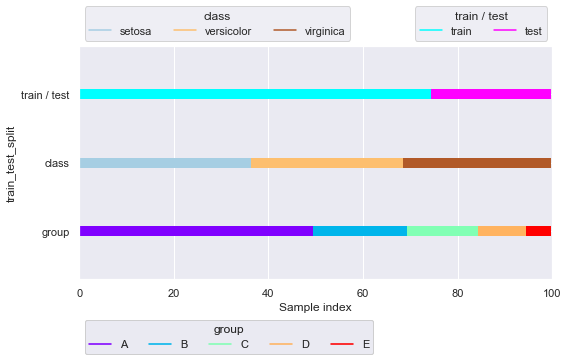

In [11]:
from sklearn.model_selection import train_test_split
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=False)
print(f"train_df: shape={train_df.shape}")
print(f"train_df.index={train_df.index}")
print(f'  value counts\n{train_df["species"].value_counts()}')
print()
print(f"test_df: shape={test_df.shape}")
print(f"test_df.index={test_df.index}")
print(f'  value counts\n{test_df["species"].value_counts()}')

plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="train_test_split")
plotter.add_plot(train_idx=train_df.index, test_idx=test_df.index)
plotter.show(custom_y_label=["train / test", "class", "group"])

train
  value counts
versicolor    26
setosa        26
virginica     23
Name: species, dtype: int64

test
  value counts
setosa        11
virginica      8
versicolor     6
Name: species, dtype: int64


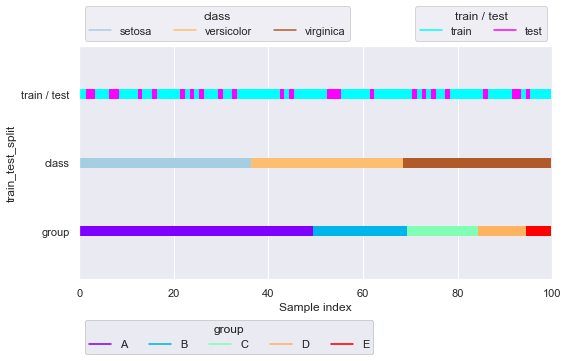

In [12]:
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=0)
print("train")
print(f'  value counts\n{train_df["species"].value_counts()}')
print()
print("test")
print(f'  value counts\n{test_df["species"].value_counts()}')
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="train_test_split")
plotter.add_plot(train_idx=train_df.index, test_idx=test_df.index)
plotter.show(custom_y_label=["train / test", "class", "group"])

train
  value counts
setosa        28
versicolor    24
virginica     23
Name: species, dtype: int64

test
  value counts
setosa        9
virginica     8
versicolor    8
Name: species, dtype: int64


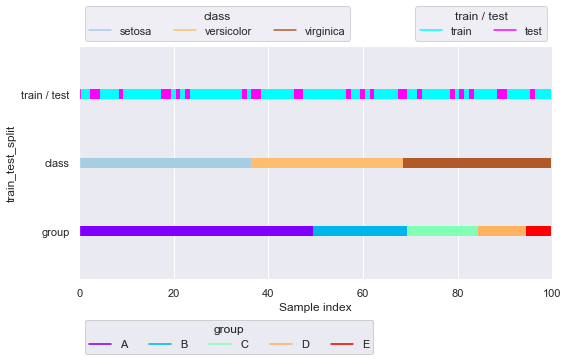

In [13]:
train_df, test_df = train_test_split(df, test_size=0.25, shuffle=True, random_state=0, stratify=y)
print("train")
print(f'  value counts\n{train_df["species"].value_counts()}')
print()
print("test")
print(f'  value counts\n{test_df["species"].value_counts()}')
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="train_test_split")
plotter.add_plot(train_idx=train_df.index, test_idx=test_df.index)
plotter.show(custom_y_label=["train / test", "class", "group"])

train_x.shape=(75, 5), train_y.shape=(75,)

test_x.shape=(25, 5), test_y.shape=(25,)


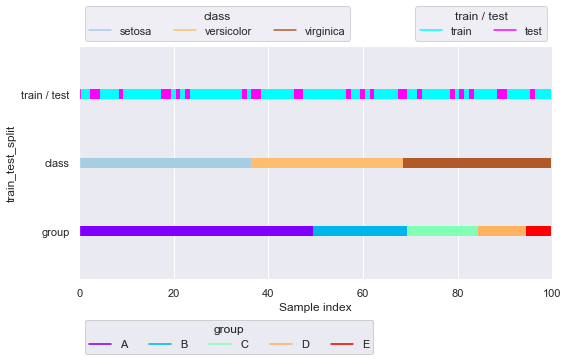

In [14]:
train_x, test_x, train_y, test_y = train_test_split(
    x, y,
    test_size=0.25, shuffle=True, random_state=0, stratify=y
)
print(f"train_x.shape={train_x.shape}, train_y.shape={train_y.shape}")
print()
print(f"test_x.shape={test_x.shape}, test_y.shape={test_y.shape}")
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="train_test_split")
plotter.add_plot(train_idx=train_x.index, test_idx=test_x.index)
plotter.show(custom_y_label=["train / test", "class", "group"])

In [15]:
# train_x, test_x, train_y, test_y = train_test_split(
#     x, y,
#     test_size=2, shuffle=True, random_state=0, stratify=y
# )

# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# ~\AppData\Local\Temp\ipykernel_13444\2492759233.py in <module>
# ----> 1 train_x, test_x, train_y, test_y = train_test_split(
#       2     x, y,
#       3     test_size=2, shuffle=True, random_state=0, stratify=y
#       4 )

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in train_test_split(test_size, train_size, random_state, shuffle, stratify, *arrays)
#    2439         cv = CVClass(test_size=n_test, train_size=n_train, random_state=random_state)
#    2440
# -> 2441         train, test = next(cv.split(X=arrays[0], y=stratify))
#    2442
#    2443     return list(

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in split(self, X, y, groups)
#    1598         """
#    1599         X, y, groups = indexable(X, y, groups)
# -> 1600         for train, test in self._iter_indices(X, y, groups):
#    1601             yield train, test
#    1602

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in _iter_indices(self, X, y, groups)
#    1951             )
#    1952         if n_test < n_classes:
# -> 1953             raise ValueError(
#    1954                 "The test_size = %d should be greater or "
#    1955                 "equal to the number of classes = %d" % (n_test, n_classes)

# ValueError: The test_size = 2 should be greater or equal to the number of classes = 3

## sklearn.model_selection.KFold

```
sklearn.model_selection.KFold(n_splits=5, *, shuffle=False, random_state=None)
・・・・データを指定した K 個に等分し，1 つを検証用，それ以外の K-1 個を学習に用います．各 fold における検証用データに重複はさせないようにします．
  - n_splits: データを何等分するかを指定できます．
  - shuffle: True の場合にデータを抽出する際に元データの順番を保持せず，ランダムなインデックスで抽出します．
  - random_state: 上記ランダム抽出に用いる乱数シードを設定します．
```


fold-0
train_idx.shape=(80,), test_idx.shape=(20,)
set(y.iloc[test_idx])={'setosa', 'virginica', 'versicolor'}
train_idx=[ 1  2  3  5  6  7  8  9 11 13 14 15 16 17 19 20 21 23 24 25 26 27 28 29
 32 34 35 36 37 38 40 41 42 43 46 47 48 49 50 51 52 54 55 56 57 58 59 60
 61 62 63 64 65 66 67 68 69 71 72 74 75 78 79 81 82 84 85 86 87 88 89 91
 92 93 94 95 96 97 98 99]
test_idx=[ 0  4 10 12 18 22 30 31 33 39 44 45 53 70 73 76 77 80 83 90]

fold-1
train_idx.shape=(80,), test_idx.shape=(20,)
set(y.iloc[test_idx])={'setosa', 'virginica', 'versicolor'}
train_idx=[ 0  1  2  3  4  6  7  8 10 12 13 14 17 18 19 20 21 22 23 24 25 27 29 30
 31 32 33 34 36 37 38 39 41 43 44 45 46 48 49 50 51 52 53 54 56 57 58 59
 60 61 62 63 64 67 68 70 71 73 74 75 76 77 78 79 80 81 82 83 84 86 87 89
 90 91 92 94 95 97 98 99]
test_idx=[ 5  9 11 15 16 26 28 35 40 42 47 55 65 66 69 72 85 88 93 96]

fold-2
train_idx.shape=(80,), test_idx.shape=(20,)
set(y.iloc[test_idx])={'setosa', 'virginica', 'versicolor'}
train_idx=[ 

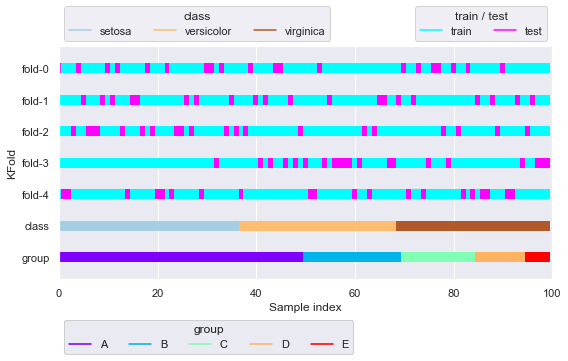

In [16]:
from sklearn.model_selection import KFold

kf = KFold(n_splits=5, shuffle=True, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="KFold")
for i, (train_idx, test_idx) in enumerate(kf.split(X=x, y=y, groups=group)):
    print(f"\nfold-{i}")
    print(f"train_idx.shape={train_idx.shape}, test_idx.shape={test_idx.shape}")
    print(f"set(y.iloc[test_idx])={set(y.iloc[test_idx])}")
    print(f"train_idx={train_idx}")
    print(f"test_idx={test_idx}")
    plotter.add_plot(train_idx=train_idx, test_idx=test_idx)
plotter.show()


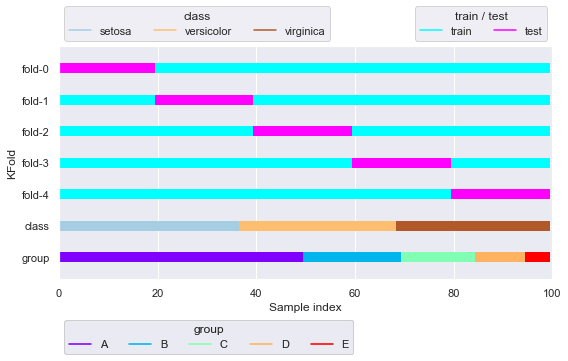

In [17]:
kf = KFold(n_splits=5, shuffle=False)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="KFold")
for i, (train_idx, test_idx) in enumerate(kf.split(X=x)):
    plotter.add_plot(train_idx=train_idx, test_idx=test_idx)
plotter.show()

## sklearn.model_selection.ShuffleSplit

```
sklearn.model_selection.ShuffleSplit(n_splits=10, *, test_size=None, train_size=None, random_state=None)
・・・・train_test.split(shuffle=True, stratify=None) を複数回作用させるような学習用／検証用データのインデックスを返すオブジェクトを生成します．各 fold における検証用データは重複します．
  - n_splits: 学習用／検証用データセットのインデックスを何回返すかを指定します．
  - test_size: 検証用データセットの割合を指定します．
  - train_size: 学習用データセットの割合を指定します．
  - random_state: ランダム抽出に用いる乱数シードを設定します．
```

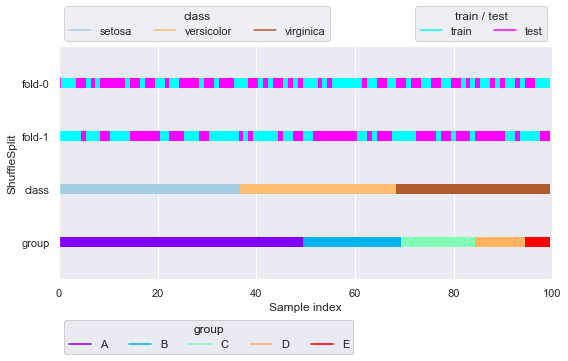

In [18]:
from sklearn.model_selection import ShuffleSplit

ss = ShuffleSplit(n_splits=2, test_size=0.5, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="ShuffleSplit")
for i, (train_idx, test_idx) in enumerate(ss.split(X=x)):
    plotter.add_plot(train_idx=train_idx, test_idx=test_idx)
plotter.show()

## sklearn.model_selection.StratifiedKFold

```
sklearn.model_selection.StratifiedKFold(n_splits=5, *, shuffle=False, random_state=None)
・・・・データを指定した K 個に等分し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割の際には，メソッド split の引数 y にてラベルやグループを指定することにより，全種類のラベルも均等に分割されます．各 fold における検証用データに重複はさせないようにします．
  - n_splits: データを何等分するかを指定できます．
  - shuffle: True の場合にデータを抽出する際に元データの順番を保持せず，ランダムなインデックスで抽出します．
  - random_state: 上記ランダム抽出に用いる乱数シードを設定します．
```


fold-0
  y[test_idx].value_counts()
setosa        13
virginica     11
versicolor    10
Name: species, dtype: int64

fold-1
  y[test_idx].value_counts()
setosa        12
versicolor    11
virginica     10
Name: species, dtype: int64

fold-2
  y[test_idx].value_counts()
setosa        12
versicolor    11
virginica     10
Name: species, dtype: int64


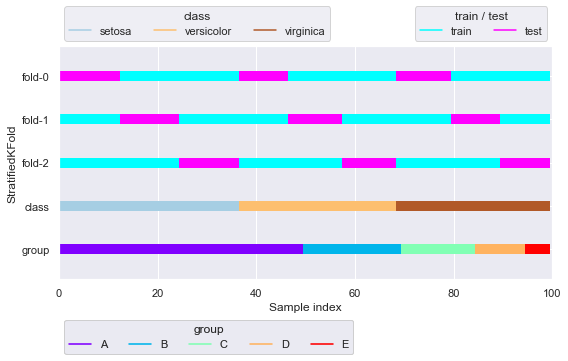

In [19]:
from sklearn.model_selection import StratifiedKFold

skf = StratifiedKFold(n_splits=3, shuffle=False)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedKFold")
for i, (train_idx, test_idx) in enumerate(skf.split(X=x, y=y)):
    print(f"\nfold-{i}")
    print(f'  y[test_idx].value_counts()\n{y[test_idx].value_counts()}')
    plotter.add_plot(train_idx=train_idx, test_idx=test_idx)
plotter.show()

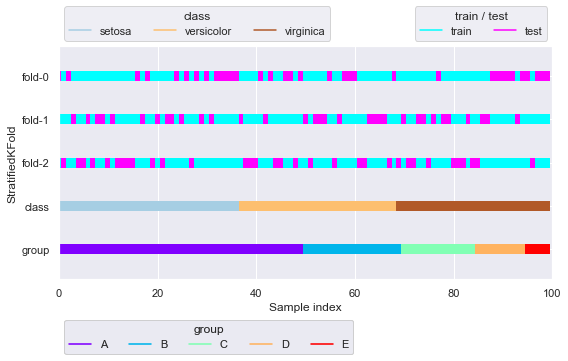

In [20]:
skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=True)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedKFold")
for i, (train_idx, test_idx) in enumerate(skf.split(X=x, y=y)):
    plotter.add_plot(train_idx=train_idx, test_idx=test_idx)
plotter.show()

## sklearn.model_selection.StratifiedShuffleSplit

```
sklearn.model_selection.StratifiedShuffleSplit(n_splits=10, *, test_size=None, train_size=None, random_state=None)
・・・・train_test.split(shuffle=True, stratify=y) を複数回作用させるような学習用／検証用データのインデックスを返すオブジェクトを生成します．各 fold における検証用データは重複します．
  - n_splits: 学習用／検証用データセットのインデックスを何回返すかを指定します．
  - test_size: 検証用データセットの割合を指定します．
  - train_size: 学習用データセットの割合を指定します．
  - random_state: ランダム抽出に用いる乱数シードを設定します．
```


fold-0
  y[test_idx].value_counts()
setosa        9
versicolor    8
virginica     8
Name: species, dtype: int64

fold-1
  y[test_idx].value_counts()
setosa        9
versicolor    8
virginica     8
Name: species, dtype: int64


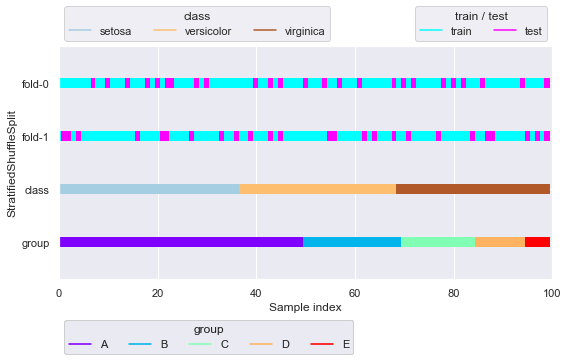

In [21]:
from sklearn.model_selection import StratifiedShuffleSplit

sss = StratifiedShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedShuffleSplit")
for i, (train_idx, test_idx) in enumerate(sss.split(X=x, y=y)):
    print(f"\nfold-{i}")
    print(f'  y[test_idx].value_counts()\n{y[test_idx].value_counts()}')
    plotter.add_plot(train_idx, test_idx)
plotter.show()

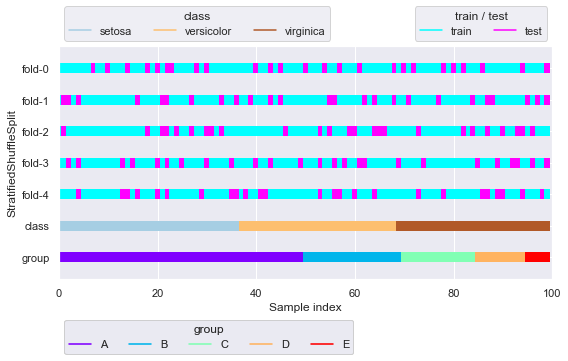

In [22]:
sss = StratifiedShuffleSplit(n_splits=5, test_size=0.25, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedShuffleSplit")
for i, (train_idx, test_idx) in enumerate(sss.split(X=x, y=y)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.GroupKFold

```
sklearn.model_selection.GroupKFold(n_splits=5)
・・・・データを指定した K 個に分割し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割の際には，メソッド split の引数 groups にて指定したグループによって，分割するインデックスを制御します．各 fold における検証用データに重複させないようにします．
  - n_splits: データを何分割するかを指定できます．
```

In [23]:
from sklearn.model_selection import GroupKFold

# gkf = GroupKFold(n_splits=10)
# for train_idx, test_idx in gkf.split(X=x, y=y, groups=group):
#     print(train_idx.shape, test_idx.shape)
# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# ~\AppData\Local\Temp\ipykernel_13444\3306961057.py in <module>
#       2
#       3 gkf = GroupKFold()
# ----> 4 for train_idx, test_idx in gkf.split(X=x, y=y, groups=y):
#       5     print(train_idx.shape, test_idx.shape)

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in split(self, X, y, groups)
#     338             )
#     339
# --> 340         for train, test in super().split(X, y, groups):
#     341             yield train, test
#     342

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in split(self, X, y, groups)
#      84         X, y, groups = indexable(X, y, groups)
#      85         indices = np.arange(_num_samples(X))
# ---> 86         for test_index in self._iter_test_masks(X, y, groups):
#      87             train_index = indices[np.logical_not(test_index)]
#      88             test_index = indices[test_index]

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in _iter_test_masks(self, X, y, groups)
#      96         By default, delegates to _iter_test_indices(X, y, groups)
#      97         """
# ---> 98         for test_index in self._iter_test_indices(X, y, groups):
#      99             test_mask = np.zeros(_num_samples(X), dtype=bool)
#     100             test_mask[test_index] = True

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in _iter_test_indices(self, X, y, groups)
#     515
#     516         if self.n_splits > n_groups:
# --> 517             raise ValueError(
#     518                 "Cannot have number of splits n_splits=%d greater"
#     519                 " than the number of groups: %d." % (self.n_splits, n_groups)

# ValueError: Cannot have number of splits n_splits=10 greater than the number of groups: 3.

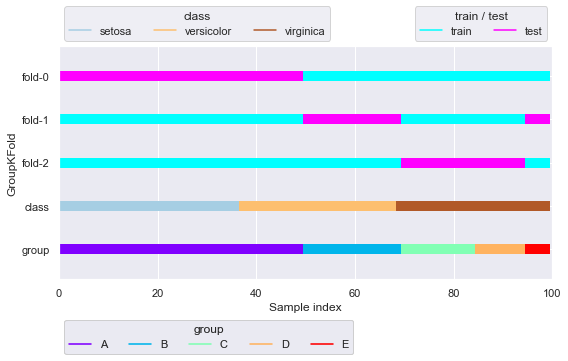

In [24]:
gkf = GroupKFold(n_splits=3)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="GroupKFold")
for i, (train_idx, test_idx) in enumerate(gkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

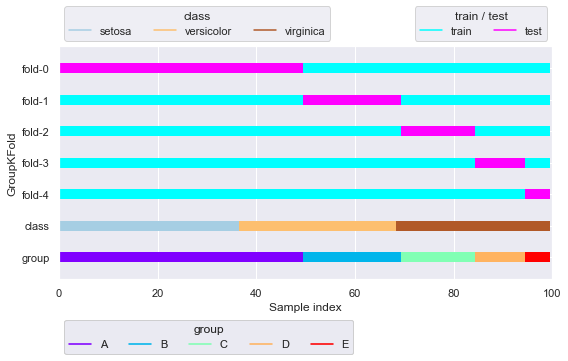

In [25]:
gkf = GroupKFold(n_splits=len(set(group)))
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="GroupKFold")
for i, (train_idx, test_idx) in enumerate(gkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.GroupShuffleSplit

```
sklearn.model_selection.GroupShuffleSplit(n_splits=5, *, test_size=None, train_size=None, random_state=None)
・・・・GroupKFold のデータ分割で，各 fold 間におけるグループの重複を許したデータ分割手法．
  - n_splits: 学習用／検証用データセットのインデックスを何回返すかを指定します．
  - test_size: 検証用データセットの割合を指定します．
  - train_size: 学習用データセットの割合を指定します．
  - random_state: ランダム抽出に用いる乱数シードを設定します．
```

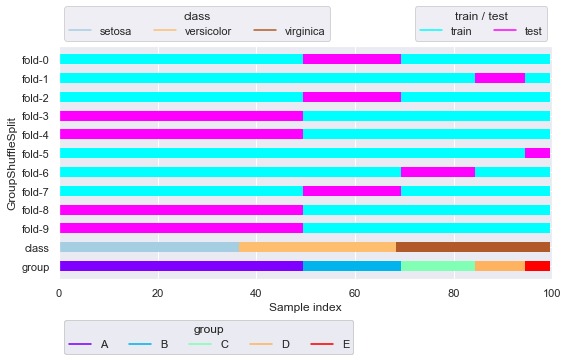

In [26]:
from sklearn.model_selection import GroupShuffleSplit

gss = GroupShuffleSplit(n_splits=10, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="GroupShuffleSplit")
for i, (train_idx, test_idx) in enumerate(gss.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

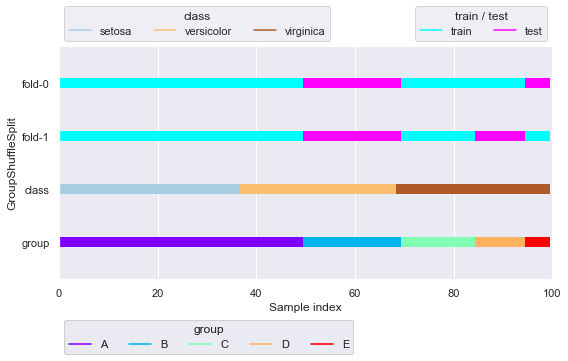

In [27]:
gss = GroupShuffleSplit(n_splits=2, test_size=0.25, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="GroupShuffleSplit")
for i, (train_idx, test_idx) in enumerate(gss.split(X=x, y=y, groups=x["area"])):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.StratifiedGroupKFold

```
sklearn.model_selection.StratifiedGroupKFold(n_splits=5, shuffle=False, random_state=None)
・・・・データを指定した K 個に分割し，1 つを検証用，それ以外の K-1 個を学習に用います．データ分割は，メソッド split の引数 y にて指定したラベル，groups にて指定したグループを用いて，グループのまとまりを使ってラベルを K 個に均等に分けるように作用します．イメージとしては，名前の通り StratifiedKFold と GroupKFold が合体したものです．各 fold における検証用データのグループは重複しません．
  - n_splits: データを何分割するかを指定できます．
  - shuffle: True の場合にデータを抽出する際に元データの順番を保持せず，ランダムなインデックスで抽出します．
  - random_state: 上記ランダム抽出に用いる乱数シードを設定します．
```

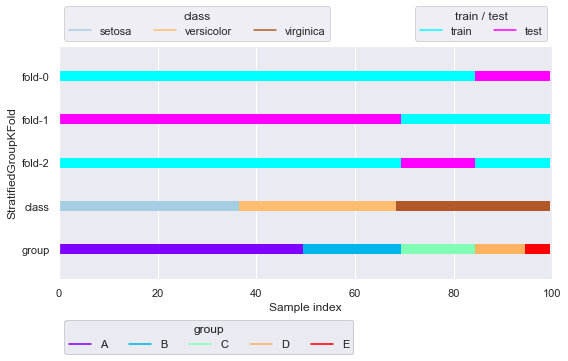

In [28]:
from sklearn.model_selection import StratifiedGroupKFold

sgkf = StratifiedGroupKFold(n_splits=3, shuffle=True, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedGroupKFold")
for i, (train_idx, test_idx) in enumerate(sgkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

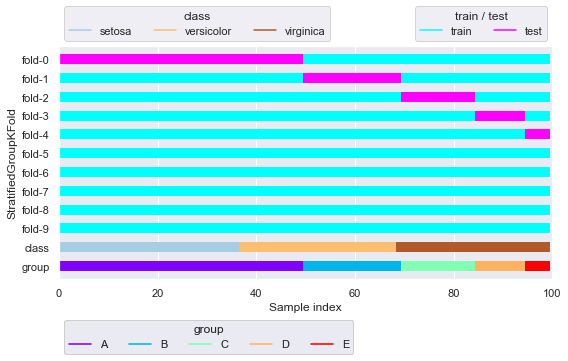

In [29]:
sgkf = StratifiedGroupKFold(n_splits=10, shuffle=False)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedGroupKFold")
for i, (train_idx, test_idx) in enumerate(sgkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

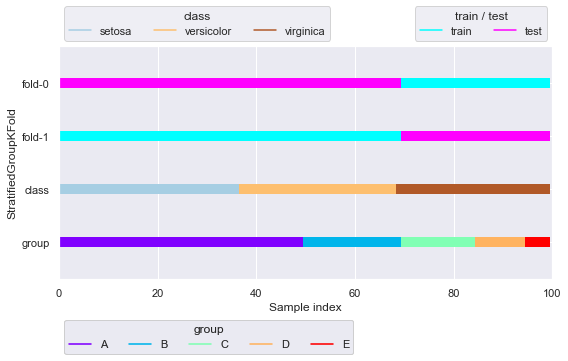

In [30]:
sgkf = StratifiedGroupKFold(n_splits=2, shuffle=True)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="StratifiedGroupKFold")
for i, (train_idx, test_idx) in enumerate(sgkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.RepeatedKFold

```
sklearn.model_selection.RepeatedKFold(*, n_splits=5, n_repeats=10, random_state=None)
・・・・KFold を n_repeats で指定した回数分行います．リピートされる各 fold 間では検証用データの重複はありませんが，各リピート間では検証用データの重複は発生します．
  - n_splits: データを何分割するかを指定できます．
  - n_repeats: KFold を繰り返す回数を指定します．
  - random_state: ランダム抽出に用いる乱数シードを設定します．
```

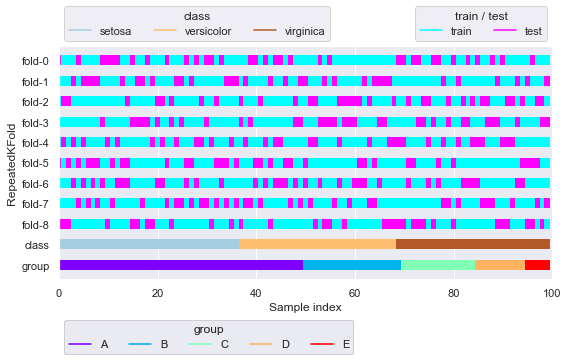

In [31]:
from sklearn.model_selection import RepeatedKFold

rkf = RepeatedKFold(n_splits=3, n_repeats=3, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="RepeatedKFold")
for i, (train_idx, test_idx) in enumerate(rkf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.RepeatedStratifiedKFold

```
sklearn.model_selection.RepeatedStratifiedKFold(*, n_splits=5, n_repeats=10, random_state=None)
・・・・StratifiedKFold を n_repeats で指定した回数分行います．リピートされる各 fold 間では検証用データの重複はありませんが，各リピート間では検証用データの重複は発生します．
  - n_splits: データを何分割するかを指定できます．
  - n_repeats: KFold を繰り返す回数を指定します．
  - random_state: ランダム抽出に用いる乱数シードを設定します．
```

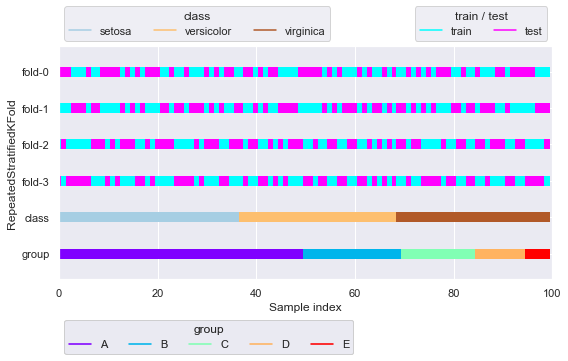

In [32]:
from sklearn.model_selection import RepeatedStratifiedKFold

rskf = RepeatedStratifiedKFold(n_splits=2, n_repeats=2, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="RepeatedStratifiedKFold")
for i, (train_idx, test_idx) in enumerate(rskf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

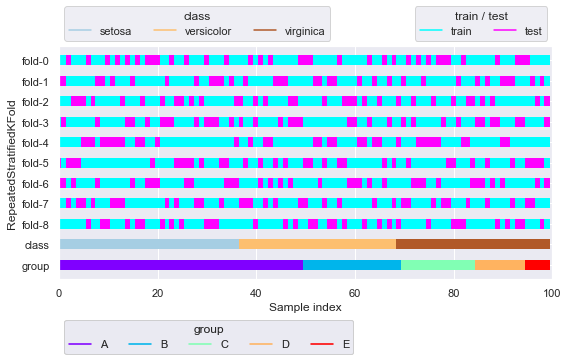

In [33]:
rskf = RepeatedStratifiedKFold(n_splits=3, n_repeats=3, random_state=42)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="RepeatedStratifiedKFold")
for i, (train_idx, test_idx) in enumerate(rskf.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.LeaveOneOut

```
sklearn.model_selection.LeaveOneOut()
・・・・一つだけを検証用データ，その他は学習用データとして分割します．
```

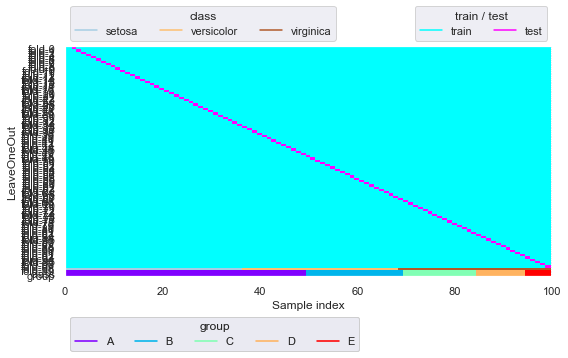

In [34]:
from sklearn.model_selection import LeaveOneOut

loo = LeaveOneOut()
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeaveOneOut")
for i, (train_idx, test_idx) in enumerate(loo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

In [35]:
print(f"train_idx={train_idx}")
print(f"test_idx={test_idx}")

train_idx=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71
 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95
 96 97 98]
test_idx=[99]


## sklearn.model_selection.LeavePOut

```
sklearn.model_selection.LeavePOut(p)
・・・・引数 p で指定した個数を検証用データ，その他を学習用データとして分割します．検証用データが複数の場合は，検証用データの組み合わせが各 fold にて重複しないように，網羅的に fold が設定されます．例えば，データ数が m 個，引数 p を n 個と設定すると，総 fold 数は数学の組み合わせの記号 C を用いて，mCn = m*(m-1) / (n*(n-1)) 個生成されます．
  - p: 検証用データの個数を指定します．
```

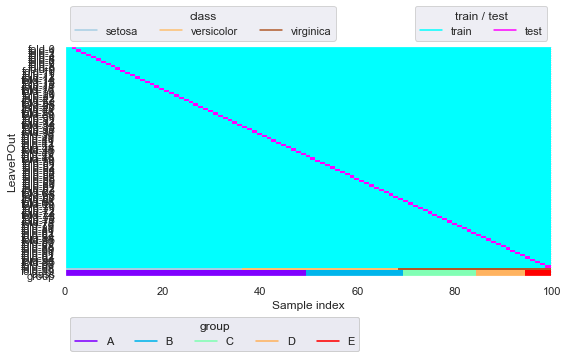

In [36]:
from sklearn.model_selection import LeavePOut

lpo = LeavePOut(p=1)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeavePOut")
for i, (train_idx, test_idx) in enumerate(lpo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

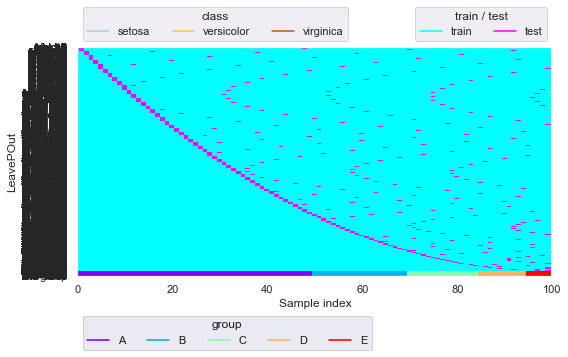

In [37]:
lpo = LeavePOut(p=2)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeavePOut")
for i, (train_idx, test_idx) in enumerate(lpo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

In [38]:
lpo = LeavePOut(p=2)
for i, (train_idx, test_idx) in enumerate(lpo.split(X=x, y=y, groups=group)):
    pass
print(i)

4949


In [39]:
int(100*99 / (2*1)) - 1

4949

In [40]:
lpo = LeavePOut(p=3)
for i, (train_idx, test_idx) in enumerate(lpo.split(X=x, y=y, groups=group)):
    pass
print(i)

161699


In [41]:
int(100*99*98 / (3*2*1)) - 1

161699

## sklearn.model_selection.LeaveOneGroupOut

```
sklearn.model_selection.LeaveOneGroupOut()
・・・・1 つのグループを検証用データとし，それ以外を学習用データとして分割します．
```

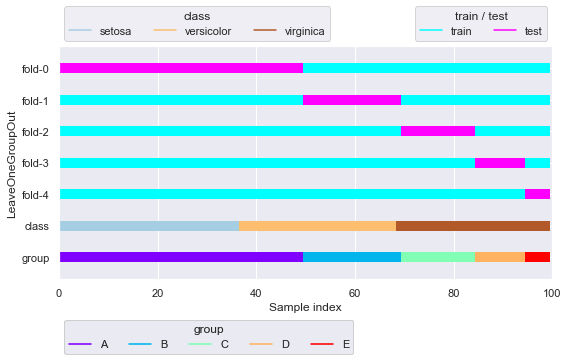

In [42]:
from sklearn.model_selection import LeaveOneGroupOut

logo = LeaveOneGroupOut()
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeaveOneGroupOut")
for i, (train_idx, test_idx) in enumerate(logo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.LeavePGroupsOut

```
sklearn.model_selection.LeavePGroupsOut(n_groups)
・・・・引数 n_groups で指定したグループ数を検証用データ，その他を学習用データとして分割します．検証用データが複数の場合は，検証用データの組み合わせが各 fold にて重複しないように，網羅的に fold が設定されます．例えば，グループ数が m 個，引数 n_groups を n 個と設定すると，総 fold 数は数学の組み合わせの記号 C を用いて，mCn = m*(m-1) / (n*(n-1)) 個生成されます．
  - n_groups: 検証用データの個数を指定します．
```

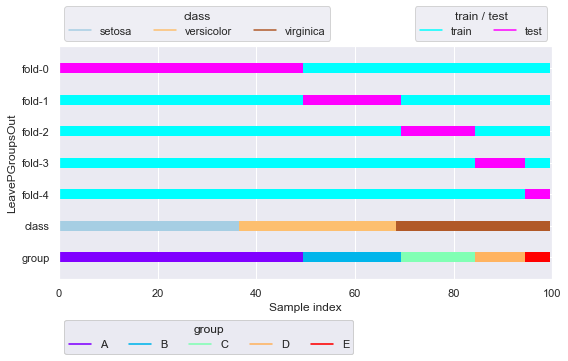

In [43]:
from sklearn.model_selection import LeavePGroupsOut

lpgo = LeavePGroupsOut(n_groups=1)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeavePGroupsOut")
for i, (train_idx, test_idx) in enumerate(lpgo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

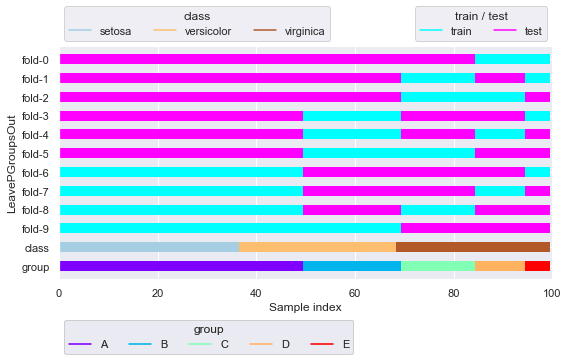

In [44]:
lpgo = LeavePGroupsOut(n_groups=3)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="LeavePGroupsOut")
for i, (train_idx, test_idx) in enumerate(lpgo.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

In [45]:
# from sklearn.model_selection import LeavePGroupsOut

# lpgo = LeavePGroupsOut(n_groups=10)
# for i, (train_idx, test_idx) in enumerate(lpgo.split(X=x, y=y, groups=group)):
    # pass

# ---------------------------------------------------------------------------
# ValueError                                Traceback (most recent call last)
# ~\AppData\Local\Temp\ipykernel_13444\3041175701.py in <module>
#       1 from sklearn.model_selection import LeavePGroupsOut
#       2 lpgo = LeavePGroupsOut(n_groups=10)
# ----> 3 for i, (train_idx, test_idx) in enumerate(lpgo.split(X=x, y=y, groups=group)):
#       4     print(f"\nfold-{i}")
#       5     print(f"train_idx.shape={train_idx.shape}, test_idx.shape={test_idx.shape}")

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in split(self, X, y, groups)
#      84         X, y, groups = indexable(X, y, groups)
#      85         indices = np.arange(_num_samples(X))
# ---> 86         for test_index in self._iter_test_masks(X, y, groups):
#      87             train_index = indices[np.logical_not(test_index)]
#      88             test_index = indices[test_index]

# ~\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\model_selection\_split.py in _iter_test_masks(self, X, y, groups)
#    1274         unique_groups = np.unique(groups)
#    1275         if self.n_groups >= len(unique_groups):
# -> 1276             raise ValueError(
#    1277                 "The groups parameter contains fewer than (or equal to) "
#    1278                 "n_groups (%d) numbers of unique groups (%s). LeavePGroupsOut "

# ValueError: The groups parameter contains fewer than (or equal to) n_groups (10) numbers of unique groups (['A' 'B' 'C' 'D' 'E']). LeavePGroupsOut expects that at least n_groups + 1 (11) unique groups be present

## sklearn.model_selection.PredefinedSplit

```
sklearn.model_selection.PredefinedSplit(test_fold)
・・・・引数 test_fold に指定した fold でデータを分割します．
  - test_fold: データ分割の仕方を与えます．
```

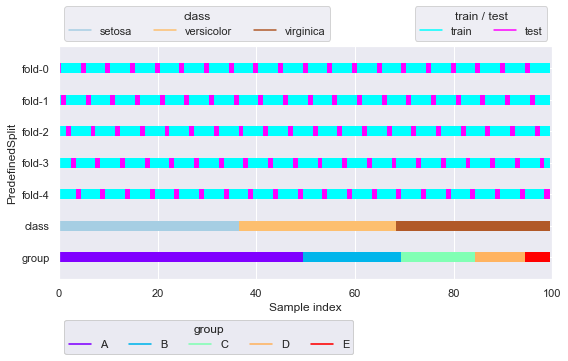

In [46]:
from sklearn.model_selection import PredefinedSplit

ps = PredefinedSplit(test_fold=list(range(5))*20)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="PredefinedSplit")
for i, (train_idx, test_idx) in enumerate(ps.split()):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

C:\Users\multi\AppData\Local\Temp\ipykernel_12440\184223740.py:1: DeprecationWarning: This function is deprecated. Please call randint(0, 1 + 1) instead
  ps = PredefinedSplit(test_fold=np.random.random_integers(low=0, high=1, size=10).tolist()*10)


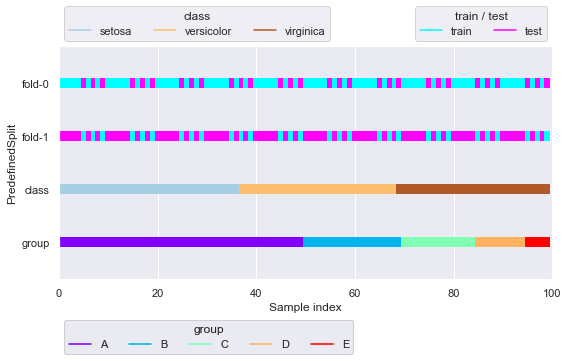

In [47]:
ps = PredefinedSplit(test_fold=np.random.random_integers(low=0, high=1, size=10).tolist()*10)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="PredefinedSplit")
for i, (train_idx, test_idx) in enumerate(ps.split()):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

## sklearn.model_selection.TimeSeriesSplit

```
sklearn.model_selection.TimeSeriesSplit(n_splits=5, *, max_train_size=None, test_size=None, gap=0)
・・・・時系列データを考慮したデータ分割手法で，検証用データを K 等分し，残りの検証用データよりも前のデータを学習用データとして用います．したがって，index=0 から始まるような検証用データにおける学習用データは取れないので，検証用データは K-1 個になります．引数 n_splits では，この K-1 を指定します．
  - n_splits: 検証用データを何等分するかを指定します．
  - max_train_size: 各 fold における学習用データの最大の個数を指定します．
  - test_size: 各 fold における検証用データの個数を指定します．
  - gap: 学習用データと検証用データを時間方向に離す個数を指定します．
```

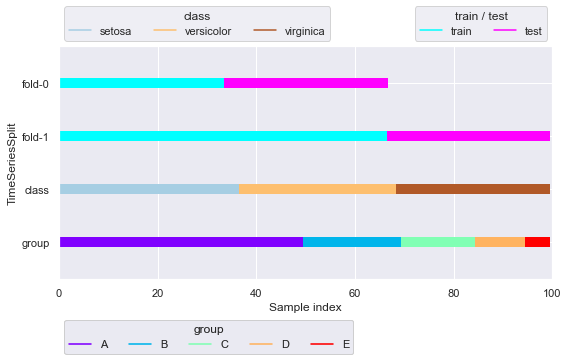

In [48]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=2)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="TimeSeriesSplit")
for i, (train_idx, test_idx) in enumerate(tss.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

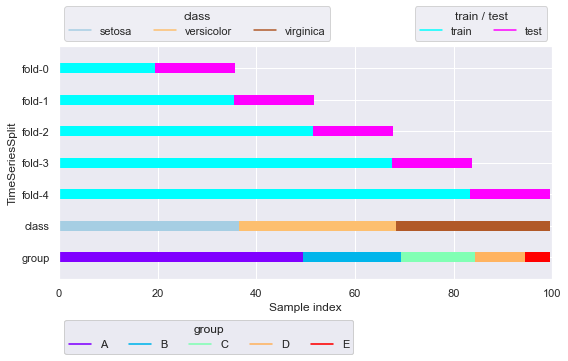

In [49]:
tss = TimeSeriesSplit(n_splits=5)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="TimeSeriesSplit")
for i, (train_idx, test_idx) in enumerate(tss.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()

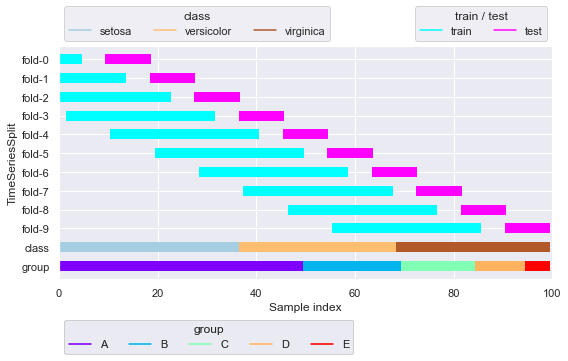

In [50]:
tss = TimeSeriesSplit(n_splits=10, max_train_size=30, gap=5)
plotter = FoldsPlotter(x=x, y=y, group=group, ylabel="TimeSeriesSplit")
for i, (train_idx, test_idx) in enumerate(tss.split(X=x, y=y, groups=group)):
    plotter.add_plot(train_idx, test_idx)
plotter.show()